# Recurrent Neural Networks for Stock Price Prediction, Deep Learning Fundamentals

## Problem Setup and Dataset Preparation

In [1]:
import pandas as pd

# Define file paths
train_path = '/Users/chayonimeu/Documents/GitHub/RNN_GRU_LSTM_-for-_Stock-Price-Prediction/GSP_Data/Google_Stock_Price_Train.csv'
test_path = '/Users/chayonimeu/Documents/GitHub/RNN_GRU_LSTM_-for-_Stock-Price-Prediction/GSP_Data/Google_Stock_Price_Test.csv'

# Load datasets
try:
    train_data = pd.read_csv(train_path)
    test_data = pd.read_csv(test_path)
    print("Datasets loaded successfully!")
except FileNotFoundError as e:
    print(f"Error: {e}")

# Display data samples
print("\nTraining Data Sample:")
print(train_data.head())
print(train_data.dtypes)

print("\nTesting Data Sample:")
print(test_data.head())
print(test_data.dtypes)

Datasets loaded successfully!

Training Data Sample:
       Date    Open    High     Low   Close      Volume
0  1/3/2012  325.25  332.83  324.97  663.59   7,380,500
1  1/4/2012  331.27  333.87  329.08  666.45   5,749,400
2  1/5/2012  329.83  330.75  326.89  657.21   6,590,300
3  1/6/2012  328.34  328.77  323.68  648.24   5,405,900
4  1/9/2012  322.04  322.29  309.46  620.76  11,688,800
Date       object
Open      float64
High      float64
Low       float64
Close      object
Volume     object
dtype: object

Testing Data Sample:
       Date    Open    High     Low   Close     Volume
0  1/3/2017  778.81  789.63  775.80  786.14  1,657,300
1  1/4/2017  788.36  791.34  783.16  786.90  1,073,000
2  1/5/2017  786.08  794.48  785.02  794.02  1,335,200
3  1/6/2017  795.26  807.90  792.20  806.15  1,640,200
4  1/9/2017  806.40  809.97  802.83  806.65  1,272,400
Date       object
Open      float64
High      float64
Low       float64
Close     float64
Volume     object
dtype: object


### Clean and Preprocess Data

In [2]:
# Clean and preprocess the data
def clean_data(data):
    # Convert 'Date' column to datetime
    data['Date'] = pd.to_datetime(data['Date'])

    # Remove commas from 'Close' and 'Volume', and convert to float
    if 'Close' in data.columns and data['Close'].dtype == 'object':
        data['Close'] = data['Close'].str.replace(',', '').astype(float)
    if 'Volume' in data.columns and data['Volume'].dtype == 'object':
        data['Volume'] = data['Volume'].str.replace(',', '').astype(float)
    
    return data

# Apply cleaning
train_data = clean_data(train_data)
test_data = clean_data(test_data)

# Display the cleaned data
print("\nCleaned Training Data Sample:")
print(train_data.head())

print("\nCleaned Testing Data Sample:")
print(test_data.head())


Cleaned Training Data Sample:
        Date    Open    High     Low   Close      Volume
0 2012-01-03  325.25  332.83  324.97  663.59   7380500.0
1 2012-01-04  331.27  333.87  329.08  666.45   5749400.0
2 2012-01-05  329.83  330.75  326.89  657.21   6590300.0
3 2012-01-06  328.34  328.77  323.68  648.24   5405900.0
4 2012-01-09  322.04  322.29  309.46  620.76  11688800.0

Cleaned Testing Data Sample:
        Date    Open    High     Low   Close     Volume
0 2017-01-03  778.81  789.63  775.80  786.14  1657300.0
1 2017-01-04  788.36  791.34  783.16  786.90  1073000.0
2 2017-01-05  786.08  794.48  785.02  794.02  1335200.0
3 2017-01-06  795.26  807.90  792.20  806.15  1640200.0
4 2017-01-09  806.40  809.97  802.83  806.65  1272400.0


### Normalize the Data

In [3]:
from sklearn.preprocessing import MinMaxScaler
import joblib

# Define scaler
scaler = MinMaxScaler()

# Select numeric columns for scaling
numeric_columns = ['Open', 'High', 'Low', 'Close', 'Volume']

# Fit scaler on training data and transform both training and testing data
train_scaled = scaler.fit_transform(train_data[numeric_columns])
test_scaled = scaler.transform(test_data[numeric_columns])

# Save the scaler for future use (e.g., inverse transformation)
joblib.dump(scaler, 'scaler.pkl')

# Convert scaled data back to DataFrame for visualization
train_scaled_df = pd.DataFrame(train_scaled, columns=numeric_columns)
test_scaled_df = pd.DataFrame(test_scaled, columns=numeric_columns)

# Display normalized data
print("\nNormalized Training Data Sample:")
print(train_scaled_df.head())

print("\nNormalized Testing Data Sample:")
print(test_scaled_df.head())


Normalized Training Data Sample:
       Open      High       Low     Close    Volume
0  0.085814  0.096401  0.090449  0.237573  0.295258
1  0.097012  0.098344  0.098235  0.241514  0.229936
2  0.094334  0.092517  0.094086  0.228781  0.263612
3  0.091562  0.088819  0.088006  0.216419  0.216179
4  0.079842  0.076718  0.061070  0.178548  0.467797

Normalized Testing Data Sample:
       Open      High       Low     Close    Volume
0  0.929552  0.949484  0.944423  0.406461  0.066055
1  0.947318  0.952677  0.958365  0.407508  0.042655
2  0.943076  0.958541  0.961888  0.417320  0.053156
3  0.960153  0.983603  0.975489  0.434037  0.065370
4  0.980877  0.987469  0.995624  0.434726  0.050641


### Create Time-Series Sequences

In [4]:
import numpy as np

def create_sequences(data, sequence_length, prediction_length):
    """
    Create sequences of data for time-series prediction.
    
    Args:
    - data (array-like): Scaled dataset (e.g., train_scaled or test_scaled).
    - sequence_length (int): Number of past days (N) to use as input.
    - prediction_length (int): Number of future days (M) to predict.

    Returns:
    - X (np.array): Input features with shape (samples, sequence_length, features).
    - y (np.array): Target predictions with shape (samples, prediction_length, features).
    """
    X, y = [], []
    for i in range(len(data) - sequence_length - prediction_length + 1):
        X.append(data[i:i + sequence_length])
        y.append(data[i + sequence_length:i + sequence_length + prediction_length])
    return np.array(X), np.array(y)

# Parameters for sequence creation
# Adjusting sequence_length to fit the test dataset (sequence_length + prediction_length <= len(test_scaled))
sequence_length = 19  # Use past 19 days to fit the 20 rows in test data
prediction_length = 1  # Predict next 1 day

# Create sequences for training and testing
X_train, y_train = create_sequences(train_scaled, sequence_length, prediction_length)
X_test, y_test = create_sequences(test_scaled, sequence_length, prediction_length)

# Display shapes
print(f"Training Input Shape: {X_train.shape}")
print(f"Training Target Shape: {y_train.shape}")
print(f"Testing Input Shape: {X_test.shape}")
print(f"Testing Target Shape: {y_test.shape}")

Training Input Shape: (1239, 19, 5)
Training Target Shape: (1239, 1, 5)
Testing Input Shape: (1, 19, 5)
Testing Target Shape: (1, 1, 5)


In [5]:
print(f"Number of rows in test dataset: {len(test_scaled)}")

Number of rows in test dataset: 20


## Model Implementation

### Implement a Vanilla RNN Model

In [6]:
from keras.models import Sequential
from keras.layers import SimpleRNN, Dense

# Define the Vanilla RNN model
def build_rnn(sequence_length, num_features):
    model = Sequential()
    model.add(SimpleRNN(units=50, return_sequences=True, input_shape=(sequence_length, num_features)))
    model.add(Dense(units=5))  # Output layer for 5 features
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# Build the model
rnn_model = build_rnn(sequence_length=19, num_features=5)

# Display the model summary
rnn_model.summary()

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)          │ (None, 19, 50)         │         2,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 19, 5)          │           255 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,055 (11.93 KB)

 Trainable params: 3,055 (11.93 KB)

 Non-trainable params: 0 (0.00 B)

### Train the RNN Model

In [7]:
# Train the model
history = rnn_model.fit(
    X_train, y_train,
    validation_split=0.1,  # Use 10% of training data for validation
    epochs=20,
    batch_size=32,
    verbose=0
)

### Evaluate the RNN Model

In [8]:
# Evaluate the model on test data
test_loss = rnn_model.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss: {test_loss}")

# Make predictions
y_pred = rnn_model.predict(X_test)

# Example of inverse scaling for predictions (if necessary)
import joblib

# Load the scaler
scaler = joblib.load('scaler.pkl')

# Reshape and inverse transform predictions
y_pred_rescaled = scaler.inverse_transform(y_pred.reshape(-1, 5))

print("\nRescaled Predictions:")
print(y_pred_rescaled)

Test Loss: 0.0010501871583983302
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step

Rescaled Predictions:
[[7.5711725e+02 7.7379956e+02 7.5847845e+02 7.3555182e+02 2.4963562e+06]
 [7.7711047e+02 7.8067767e+02 7.5422473e+02 7.4614307e+02 1.7171209e+06]
 [7.7568085e+02 7.5360156e+02 7.4652539e+02 7.6867712e+02 1.7415730e+06]
 [7.7698755e+02 7.7034912e+02 7.4687225e+02 7.8305762e+02 1.9445225e+06]
 [7.7981512e+02 7.8377148e+02 7.5245728e+02 7.9659259e+02 2.7327462e+06]
 [8.0508691e+02 7.9303040e+02 7.5970819e+02 7.9578772e+02 1.4905898e+06]
 [7.9365295e+02 7.9658691e+02 7.5419159e+02 7.9477301e+02 1.9093476e+06]
 [7.9248138e+02 7.9185461e+02 7.7581158e+02 8.0390112e+02 2.1276490e+06]
 [7.9737244e+02 8.0034039e+02 7.6455817e+02 7.9016589e+02 1.9235289e+06]
 [7.9134613e+02 7.9473468e+02 7.7223462e+02 7.9853961e+02 1.9013770e+06]
 [7.9195764e+02 7.8890082e+02 7.6877716e+02 7.8168555e+02 1.9236284e+06]
 [7.8674640e+02 7.9545081e+02 7.6899127e+02 7.7933313e+02 1.8865186e+06]
 [7.8977405e+02 7.9550726e+02 

### Visualize Results

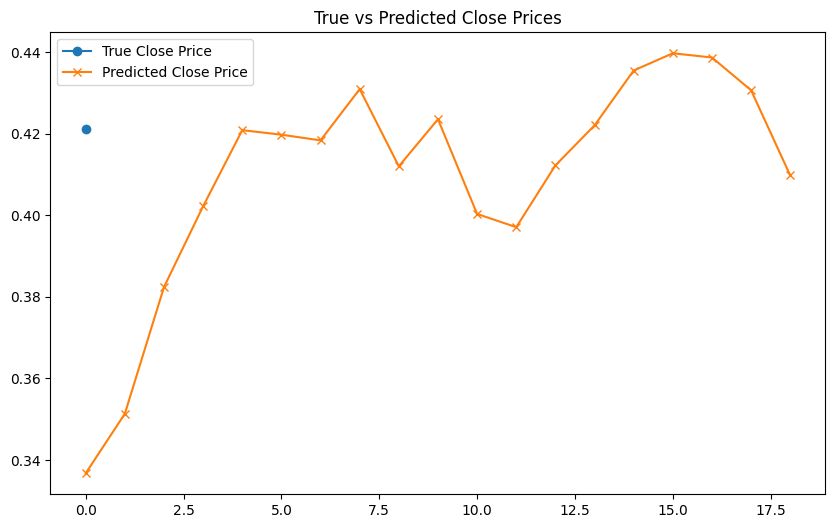

In [9]:
import matplotlib.pyplot as plt

# Plot true vs predicted values for the 'Close' feature
true_close = y_test.reshape(-1, 5)[:, 3]  # Extract true 'Close' values
pred_close = y_pred.reshape(-1, 5)[:, 3]  # Extract predicted 'Close' values

plt.figure(figsize=(10, 6))
plt.plot(true_close, label='True Close Price', marker='o')
plt.plot(pred_close, label='Predicted Close Price', marker='x')
plt.title('True vs Predicted Close Prices')
plt.legend()
plt.show()

## Implement GRU Model

In [10]:
from keras.layers import GRU

# Define the GRU model
def build_gru(sequence_length, num_features):
    model = Sequential()
    model.add(GRU(units=50, return_sequences=True, input_shape=(sequence_length, num_features)))
    model.add(Dense(units=5))  # Output layer for 5 features
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# Build the model
gru_model = build_gru(sequence_length=19, num_features=5)

# Display the model summary
gru_model.summary()

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 19, 50)         │         8,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 19, 5)          │           255 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,805 (34.39 KB)

 Trainable params: 8,805 (34.39 KB)

 Non-trainable params: 0 (0.00 B)

### Train the GRU Model

In [11]:
# Train the GRU model
gru_history = gru_model.fit(
    X_train, y_train,
    validation_split=0.1,  # Use 10% of training data for validation
    epochs=20,
    batch_size=32,
    verbose=0
)

### Evaluate the GRU Model

In [12]:
# Evaluate the model on test data
gru_test_loss = gru_model.evaluate(X_test, y_test, verbose=0)
print(f"GRU Test Loss: {gru_test_loss}")

# Make predictions
gru_y_pred = gru_model.predict(X_test)

# Rescale the predictions (if necessary)
gru_y_pred_rescaled = scaler.inverse_transform(gru_y_pred.reshape(-1, 5))

print("\nGRU Rescaled Predictions:")
print(gru_y_pred_rescaled)

GRU Test Loss: 0.0010080750798806548
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step

GRU Rescaled Predictions:
[[7.6686786e+02 7.8098120e+02 7.8086145e+02 7.4515460e+02 2.1008378e+06]
 [7.7206287e+02 7.9339191e+02 7.5945789e+02 7.3315936e+02 1.8564071e+06]
 [7.7488312e+02 7.8983405e+02 7.6391406e+02 7.3537671e+02 2.1154632e+06]
 [7.8755176e+02 8.0127448e+02 7.7664343e+02 7.4825623e+02 2.1795975e+06]
 [7.9088885e+02 8.0708978e+02 7.8041266e+02 7.5130548e+02 2.1304232e+06]
 [7.8969623e+02 8.0722876e+02 7.7944507e+02 7.5277850e+02 2.1059315e+06]
 [7.8787457e+02 8.0585760e+02 7.7763434e+02 7.5737897e+02 2.0834635e+06]
 [7.8614008e+02 8.0458704e+02 7.7680316e+02 7.5869257e+02 2.0846895e+06]
 [7.9041125e+02 8.0881439e+02 7.8127533e+02 7.5952429e+02 2.0072752e+06]
 [7.8528979e+02 8.0436761e+02 7.7660553e+02 7.5855200e+02 2.0278134e+06]
 [7.8533710e+02 8.0421112e+02 7.7739410e+02 7.5995624e+02 1.9992859e+06]
 [7.8684247e+02 8.0565918e+02 7.7872620e+02 7.5851550e+02 1.9441360e+06]
 [7.8541339e+02 8.0452

### Visualize GRU Results

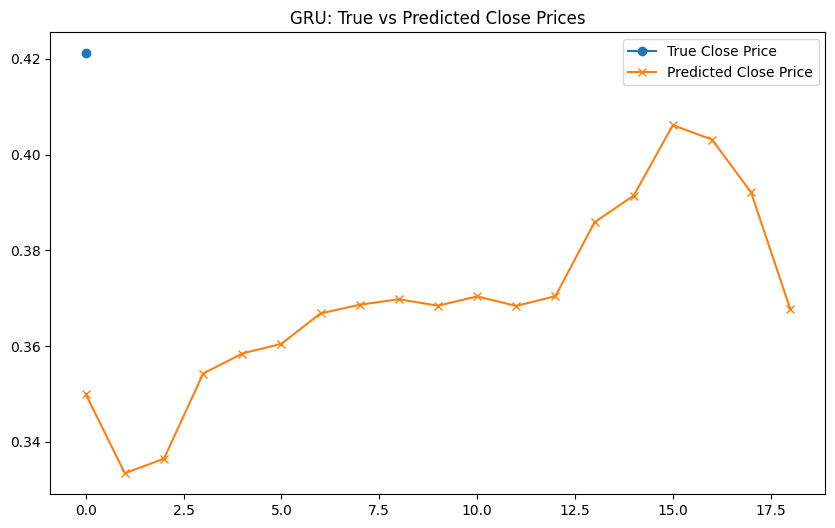

In [13]:
# Plot true vs predicted values for the 'Close' feature
gru_true_close = y_test.reshape(-1, 5)[:, 3]  # Extract true 'Close' values
gru_pred_close = gru_y_pred.reshape(-1, 5)[:, 3]  # Extract predicted 'Close' values

plt.figure(figsize=(10, 6))
plt.plot(gru_true_close, label='True Close Price', marker='o')
plt.plot(gru_pred_close, label='Predicted Close Price', marker='x')
plt.title('GRU: True vs Predicted Close Prices')
plt.legend()
plt.show()

## Implement LSTM Model

In [14]:
from keras.layers import LSTM

# Define the LSTM model
def build_lstm(sequence_length, num_features):
    model = Sequential()
    model.add(LSTM(units=50, return_sequences=True, input_shape=(sequence_length, num_features)))
    model.add(Dense(units=5))  # Output layer for 5 features
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# Build the model
lstm_model = build_lstm(sequence_length=19, num_features=5)

# Display the model summary
lstm_model.summary()

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 19, 50)         │        11,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 19, 5)          │           255 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,455 (44.75 KB)

 Trainable params: 11,455 (44.75 KB)

 Non-trainable params: 0 (0.00 B)

### Train the LSTM Model

In [15]:
# Train the LSTM model
lstm_history = lstm_model.fit(
    X_train, y_train,
    validation_split=0.1,  # Use 10% of training data for validation
    epochs=20,
    batch_size=32,
    verbose=0
)

### Evaluate the LSTM Model

In [16]:
# Evaluate the model on test data
lstm_test_loss = lstm_model.evaluate(X_test, y_test, verbose=0)
print(f"LSTM Test Loss: {lstm_test_loss}")

# Make predictions
lstm_y_pred = lstm_model.predict(X_test)

# Rescale the predictions (if necessary)
lstm_y_pred_rescaled = scaler.inverse_transform(lstm_y_pred.reshape(-1, 5))

print("\nLSTM Rescaled Predictions:")
print(lstm_y_pred_rescaled)

LSTM Test Loss: 0.0008344226516783237
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step

LSTM Rescaled Predictions:
[[7.7597833e+02 7.6649512e+02 7.2866858e+02 7.2764154e+02 2.3078308e+06]
 [7.6899573e+02 7.8285321e+02 7.7215820e+02 7.5872052e+02 1.5469250e+06]
 [7.6219025e+02 7.7611322e+02 7.6407440e+02 7.6125226e+02 1.5632060e+06]
 [7.8489044e+02 7.9438818e+02 7.7611652e+02 7.6109833e+02 1.7413246e+06]
 [7.9474652e+02 8.0242151e+02 7.8198615e+02 7.6173792e+02 1.7658901e+06]
 [7.9804071e+02 8.0477167e+02 7.8449054e+02 7.6451984e+02 1.8055046e+06]
 [7.9811615e+02 8.0457294e+02 7.8547992e+02 7.7001239e+02 1.8587855e+06]
 [7.9854919e+02 8.0515558e+02 7.8784375e+02 7.7550055e+02 1.9494216e+06]
 [8.0094513e+02 8.0789996e+02 7.9130682e+02 7.8003534e+02 1.9831922e+06]
 [7.9639795e+02 8.0404645e+02 7.8863123e+02 7.8291913e+02 2.0480131e+06]
 [7.9583252e+02 8.0378607e+02 7.8849420e+02 7.8541101e+02 2.0981020e+06]
 [7.9627478e+02 8.0459912e+02 7.8915137e+02 7.8523730e+02 2.1033818e+06]
 [7.9450452e+02 8.03

### Visualize LSTM Results

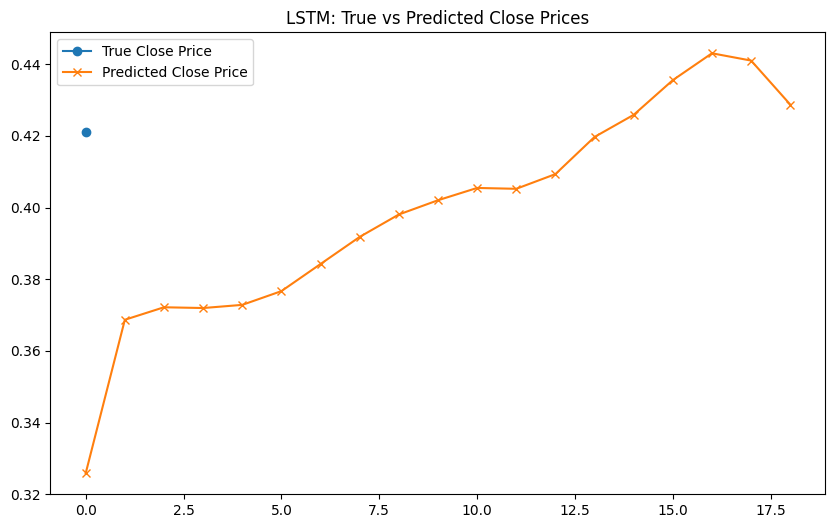

In [17]:
# Plot true vs predicted values for the 'Close' feature
lstm_true_close = y_test.reshape(-1, 5)[:, 3]  # Extract true 'Close' values
lstm_pred_close = lstm_y_pred.reshape(-1, 5)[:, 3]  # Extract predicted 'Close' values

plt.figure(figsize=(10, 6))
plt.plot(lstm_true_close, label='True Close Price', marker='o')
plt.plot(lstm_pred_close, label='Predicted Close Price', marker='x')
plt.title('LSTM: True vs Predicted Close Prices')
plt.legend()
plt.show()

## hyperparameter tuning

In [18]:
from keras.models import Sequential
from keras.layers import SimpleRNN, GRU, LSTM, Dense
from keras.optimizers import Adam
from sklearn.model_selection import ParameterGrid

# Define the search space
param_grid = {
    'units': [32, 50, 100],
    'learning_rate': [0.001, 0.01],
    'batch_size': [16, 32],
    'epochs': [10, 20],
}

# Grid of parameters
grid = ParameterGrid(param_grid)

### Define Model Training Function

In [19]:
def train_and_evaluate_model(model_type, params, X_train, y_train, X_val, y_val):
    """
    Train and evaluate a model with given parameters.
    
    Args:
    - model_type (str): 'RNN', 'GRU', or 'LSTM'.
    - params (dict): Dictionary of hyperparameters.
    - X_train, y_train: Training data.
    - X_val, y_val: Validation data.

    Returns:
    - val_loss (float): Validation loss.
    """
    # Build the model
    model = Sequential()
    if model_type == 'RNN':
        model.add(SimpleRNN(params['units'], return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
    elif model_type == 'GRU':
        model.add(GRU(params['units'], return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
    elif model_type == 'LSTM':
        model.add(LSTM(params['units'], return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dense(5))  # Output layer

    # Compile the model
    optimizer = Adam(learning_rate=params['learning_rate'])
    model.compile(optimizer=optimizer, loss='mean_squared_error')

    # Train the model
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=params['epochs'],
        batch_size=params['batch_size'],
        verbose=0
    )

    # Return the validation loss
    val_loss = min(history.history['val_loss'])
    return val_loss

### Perform Hyperparameter Tuning

In [20]:
# Split training data into training and validation sets
split_idx = int(0.9 * X_train.shape[0])
X_train_split, X_val = X_train[:split_idx], X_train[split_idx:]
y_train_split, y_val = y_train[:split_idx], y_train[split_idx:]

# Perform tuning for RNN, GRU, and LSTM
best_params = {}
best_val_loss = float('inf')

for model_type in ['RNN', 'GRU', 'LSTM']:
    print(f"Tuning {model_type}...")
    for params in grid:
        val_loss = train_and_evaluate_model(model_type, params, X_train_split, y_train_split, X_val, y_val)
        print(f"Params: {params}, Val Loss: {val_loss}")
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_params[model_type] = params

# Display the best hyperparameters for each model
print("\nBest Hyperparameters:")
for model_type, params in best_params.items():
    print(f"{model_type}: {params}")

Tuning RNN...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Params: {'batch_size': 16, 'epochs': 10, 'learning_rate': 0.001, 'units': 32}, Val Loss: 0.0017815239261835814
Params: {'batch_size': 16, 'epochs': 10, 'learning_rate': 0.001, 'units': 50}, Val Loss: 0.0024691089056432247
Params: {'batch_size': 16, 'epochs': 10, 'learning_rate': 0.001, 'units': 100}, Val Loss: 0.001683059148490429
Params: {'batch_size': 16, 'epochs': 10, 'learning_rate': 0.01, 'units': 32}, Val Loss: 0.0013689001789316535
Params: {'batch_size': 16, 'epochs': 10, 'learning_rate': 0.01, 'units': 50}, Val Loss: 0.0014628295321017504
Params: {'batch_size': 16, 'epochs': 10, 'learning_rate': 0.01, 'units': 100}, Val Loss: 0.001627237070351839
Params: {'batch_size': 16, 'epochs': 20, 'learning_rate': 0.001, 'units': 32}, Val Loss: 0.001547688152641058
Params: {'batch_size': 16, 'epochs': 20, 'learning_rate': 0.001, 'units': 50}, Val Loss: 0.0019309540512040257
Params: {'batch_size': 16, 'epochs': 20, 'learning_rate': 0.001, 'units': 100}, Val Loss: 0.0016840401804074645
Para

### Train RNN with Optimized Hyperparameters

In [22]:
# Rebuild the RNN model with optimized hyperparameters
from keras.optimizers import Adam

def build_optimized_rnn(units, learning_rate):
    model = Sequential()
    model.add(SimpleRNN(units=units, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dense(units=5))  # Output layer
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

# Build the RNN model with the best hyperparameters
optimized_rnn = build_optimized_rnn(units=50, learning_rate=0.01)

# Train the model
rnn_optimized_history = optimized_rnn.fit(
    X_train, y_train,
    validation_split=0.1,  # Use 10% for validation
    epochs=20,            # Best parameter
    batch_size=16,        # Best parameter
    verbose=0
)

# Evaluate the optimized RNN on the test data
rnn_optimized_test_loss = optimized_rnn.evaluate(X_test, y_test, verbose=0)
print(f"Optimized RNN Test Loss: {rnn_optimized_test_loss}")

# Make predictions
rnn_optimized_y_pred = optimized_rnn.predict(X_test)

# Rescale predictions
rnn_optimized_y_pred_rescaled = scaler.inverse_transform(rnn_optimized_y_pred.reshape(-1, 5))

print("\nOptimized RNN Rescaled Predictions:")
print(rnn_optimized_y_pred_rescaled)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Optimized RNN Test Loss: 0.0019272250356152654
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step

Optimized RNN Rescaled Predictions:
[[7.6439581e+02 7.7776019e+02 7.6467181e+02 7.4435730e+02 1.2532912e+06]
 [7.5192487e+02 7.5199109e+02 7.5443549e+02 7.2962610e+02 9.1085281e+05]
 [7.5446149e+02 7.5211713e+02 7.5476312e+02 7.4976697e+02 1.5662191e+06]
 [7.7360571e+02 7.6806226e+02 7.6149200e+02 7.5404492e+02 1.5421390e+06]
 [7.7631830e+02 7.7766113e+02 7.6905042e+02 7.5729376e+02 1.4319608e+06]
 [7.7829999e+02 7.7215747e+02 7.7197314e+02 7.5625275e+02 1.4072084e+06]
 [7.7980005e+02 7.7506720e+02 7.7173694e+02 7.6082520e+02 1.8345292e+06]
 [7.7415454e+02 7.7653613e+02 7.7647736e+02 7.5855579e+02 1.3482374e+06]
 [7.8185889e+02 7.8373615e+02 7.7412817e+02 7.6231006e+02 1.7476596e+06]
 [7.7796899e+02 7.7217468e+02 7.7017413e+02 7.6071222e+02 1.3770551e+06]
 [7.7663562e+02 7.7092255e+02 7.6973743e+02 7.6354413e+02 1.7388621e+06]
 [7.7548297e+02 7.7510474e+02 7.7342560e+02 7.5857581e+02 1.4535895e+06]
 [

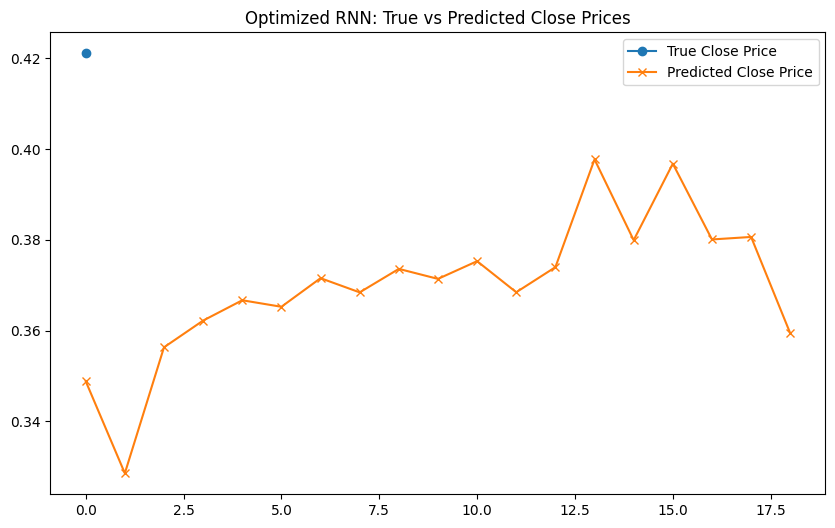

In [23]:
# Plot true vs predicted values for the 'Close' feature
rnn_optimized_true_close = y_test.reshape(-1, 5)[:, 3]  # True 'Close' values
rnn_optimized_pred_close = rnn_optimized_y_pred.reshape(-1, 5)[:, 3]  # Predicted 'Close' values

plt.figure(figsize=(10, 6))
plt.plot(rnn_optimized_true_close, label='True Close Price', marker='o')
plt.plot(rnn_optimized_pred_close, label='Predicted Close Price', marker='x')
plt.title('Optimized RNN: True vs Predicted Close Prices')
plt.legend()
plt.show()

### Perform GRU Hyperparameter Tuning

In [24]:
# Perform tuning for GRU
best_gru_params = {}
best_gru_val_loss = float('inf')

print("Tuning GRU...")
for params in grid:
    val_loss = train_and_evaluate_model('GRU', params, X_train_split, y_train_split, X_val, y_val)
    print(f"Params: {params}, Val Loss: {val_loss}")
    if val_loss < best_gru_val_loss:
        best_gru_val_loss = val_loss
        best_gru_params = params

# Display the best hyperparameters for GRU
print("\nBest Hyperparameters for GRU:")
print(best_gru_params)

Tuning GRU...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Params: {'batch_size': 16, 'epochs': 10, 'learning_rate': 0.001, 'units': 32}, Val Loss: 0.0025087990798056126
Params: {'batch_size': 16, 'epochs': 10, 'learning_rate': 0.001, 'units': 50}, Val Loss: 0.0016863644123077393
Params: {'batch_size': 16, 'epochs': 10, 'learning_rate': 0.001, 'units': 100}, Val Loss: 0.0018317920621484518
Params: {'batch_size': 16, 'epochs': 10, 'learning_rate': 0.01, 'units': 32}, Val Loss: 0.001833996269851923
Params: {'batch_size': 16, 'epochs': 10, 'learning_rate': 0.01, 'units': 50}, Val Loss: 0.0017364667728543282
Params: {'batch_size': 16, 'epochs': 10, 'learning_rate': 0.01, 'units': 100}, Val Loss: 0.0015013797674328089
Params: {'batch_size': 16, 'epochs': 20, 'learning_rate': 0.001, 'units': 32}, Val Loss: 0.0015276535414159298
Params: {'batch_size': 16, 'epochs': 20, 'learning_rate': 0.001, 'units': 50}, Val Loss: 0.0016157260397449136
Params: {'batch_size': 16, 'epochs': 20, 'learning_rate': 0.001, 'units': 100}, Val Loss: 0.001432560384273529
Par

In [26]:
# Rebuild the GRU model with optimized hyperparameters
def build_optimized_gru(units, learning_rate):
    model = Sequential()
    model.add(GRU(units=units, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dense(units=5))  # Output layer
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

# Build the GRU model with the best hyperparameters
optimized_gru = build_optimized_gru(units=50, learning_rate=0.01)

# Train the model
gru_optimized_history = optimized_gru.fit(
    X_train, y_train,
    validation_split=0.1,  # Use 10% for validation
    epochs=20,            # Best parameter
    batch_size=16,        # Best parameter
    verbose=0
)

# Evaluate the optimized GRU on the test data
gru_optimized_test_loss = optimized_gru.evaluate(X_test, y_test, verbose=0)
print(f"Optimized GRU Test Loss: {gru_optimized_test_loss}")

# Make predictions
gru_optimized_y_pred = optimized_gru.predict(X_test)

# Rescale predictions
gru_optimized_y_pred_rescaled = scaler.inverse_transform(gru_optimized_y_pred.reshape(-1, 5))

print("\nOptimized GRU Rescaled Predictions:")
print(gru_optimized_y_pred_rescaled)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Optimized GRU Test Loss: 0.0013492803554981947
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step

Optimized GRU Rescaled Predictions:
[[7.6317078e+02 7.6253613e+02 7.6051337e+02 7.9599316e+02 1.2156849e+06]
 [7.6499866e+02 7.6425330e+02 7.6468903e+02 8.1375159e+02 1.3260294e+06]
 [7.6886761e+02 7.6574341e+02 7.6664661e+02 8.1198065e+02 1.2414376e+06]
 [7.7572717e+02 7.7222699e+02 7.7154364e+02 8.2417273e+02 1.2986936e+06]
 [7.7992310e+02 7.7617853e+02 7.7516248e+02 8.2503625e+02 1.2686686e+06]
 [7.8035626e+02 7.7661444e+02 7.7572626e+02 8.2377222e+02 1.2675330e+06]
 [7.7995026e+02 7.7626172e+02 7.7535486e+02 8.2587006e+02 1.2875642e+06]
 [7.7971460e+02 7.7632458e+02 7.7476581e+02 8.2419891e+02 1.3051649e+06]
 [7.8393591e+02 7.8015802e+02 7.7868927e+02 8.2592120e+02 1.2754011e+06]
 [7.8078143e+02 7.7762146e+02 7.7582983e+02 8.2291058e+02 1.3130582e+06]
 [7.8160675e+02 7.7824622e+02 7.7620081e+02 8.2400311e+02 1.3156329e+06]
 [7.8296106e+02 7.7958063e+02 7.7758740e+02 8.2186530e+02 1.2821495e+06]
 [

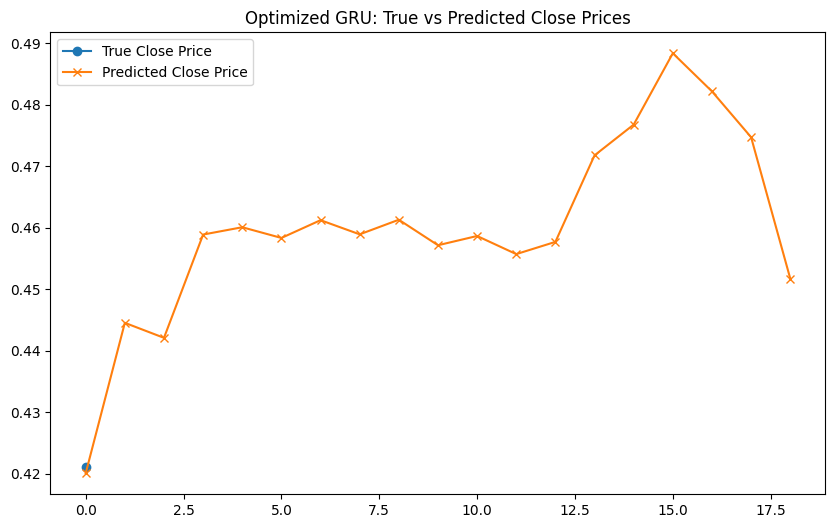

In [27]:
# Plot true vs predicted values for the 'Close' feature
gru_optimized_true_close = y_test.reshape(-1, 5)[:, 3]  # True 'Close' values
gru_optimized_pred_close = gru_optimized_y_pred.reshape(-1, 5)[:, 3]  # Predicted 'Close' values

plt.figure(figsize=(10, 6))
plt.plot(gru_optimized_true_close, label='True Close Price', marker='o')
plt.plot(gru_optimized_pred_close, label='Predicted Close Price', marker='x')
plt.title('Optimized GRU: True vs Predicted Close Prices')
plt.legend()
plt.show()

### Perform LSTM Hyperparameter Tuning

In [28]:
# Perform tuning for LSTM
best_lstm_params = {}
best_lstm_val_loss = float('inf')

print("Tuning LSTM...")
for params in grid:
    val_loss = train_and_evaluate_model('LSTM', params, X_train_split, y_train_split, X_val, y_val)
    print(f"Params: {params}, Val Loss: {val_loss}")
    if val_loss < best_lstm_val_loss:
        best_lstm_val_loss = val_loss
        best_lstm_params = params

# Display the best hyperparameters for LSTM
print("\nBest Hyperparameters for LSTM:")
print(best_lstm_params)

Tuning LSTM...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Params: {'batch_size': 16, 'epochs': 10, 'learning_rate': 0.001, 'units': 32}, Val Loss: 0.004444259684532881
Params: {'batch_size': 16, 'epochs': 10, 'learning_rate': 0.001, 'units': 50}, Val Loss: 0.0029430247377604246
Params: {'batch_size': 16, 'epochs': 10, 'learning_rate': 0.001, 'units': 100}, Val Loss: 0.0018583902856335044
Params: {'batch_size': 16, 'epochs': 10, 'learning_rate': 0.01, 'units': 32}, Val Loss: 0.0016658472595736384
Params: {'batch_size': 16, 'epochs': 10, 'learning_rate': 0.01, 'units': 50}, Val Loss: 0.0016929367557168007
Params: {'batch_size': 16, 'epochs': 10, 'learning_rate': 0.01, 'units': 100}, Val Loss: 0.001413400168530643
Params: {'batch_size': 16, 'epochs': 20, 'learning_rate': 0.001, 'units': 32}, Val Loss: 0.001879823044873774
Params: {'batch_size': 16, 'epochs': 20, 'learning_rate': 0.001, 'units': 50}, Val Loss: 0.001665136544033885
Params: {'batch_size': 16, 'epochs': 20, 'learning_rate': 0.001, 'units': 100}, Val Loss: 0.0017445775447413325
Param

### Train LSTM with Optimized Hyperparameters

In [30]:
# Rebuild the LSTM model with optimized hyperparameters
def build_optimized_lstm(units, learning_rate):
    model = Sequential()
    model.add(LSTM(units=units, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dense(units=5))  # Output layer
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

# Build the LSTM model with the best hyperparameters
optimized_lstm = build_optimized_lstm(units=32, learning_rate=0.01)

# Train the model
lstm_optimized_history = optimized_lstm.fit(
    X_train, y_train,
    validation_split=0.1,  # Use 10% for validation
    epochs=20,            # Best parameter
    batch_size=16,        # Best parameter
    verbose=0
)

# Evaluate the optimized LSTM on the test data
lstm_optimized_test_loss = optimized_lstm.evaluate(X_test, y_test, verbose=0)
print(f"Optimized LSTM Test Loss: {lstm_optimized_test_loss}")

# Make predictions
lstm_optimized_y_pred = optimized_lstm.predict(X_test)

# Rescale predictions
lstm_optimized_y_pred_rescaled = scaler.inverse_transform(lstm_optimized_y_pred.reshape(-1, 5))

print("\nOptimized LSTM Rescaled Predictions:")
print(lstm_optimized_y_pred_rescaled)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Optimized LSTM Test Loss: 0.001768183778040111
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step

Optimized LSTM Rescaled Predictions:
[[7.7467432e+02 7.7918579e+02 7.6285931e+02 7.3558734e+02 1.6544029e+06]
 [7.6205835e+02 7.6342157e+02 7.4654053e+02 7.1906110e+02 2.0502368e+06]
 [7.6885999e+02 7.7129535e+02 7.5296356e+02 7.3106213e+02 2.0316986e+06]
 [7.7833557e+02 7.8167474e+02 7.6219775e+02 7.3952368e+02 2.0697816e+06]
 [7.8562079e+02 7.8912988e+02 7.6937189e+02 7.3947437e+02 2.0600764e+06]
 [7.8751929e+02 7.9118103e+02 7.7080096e+02 7.3910168e+02 2.0703625e+06]
 [7.8736041e+02 7.9122607e+02 7.7029846e+02 7.4178845e+02 2.0804946e+06]
 [7.8737115e+02 7.9144788e+02 7.6998132e+02 7.4240692e+02 2.1012242e+06]
 [7.9067413e+02 7.9484094e+02 7.7340491e+02 7.4295184e+02 2.0796000e+06]
 [7.8803857e+02 7.9229529e+02 7.7035077e+02 7.4249377e+02 2.1066572e+06]
 [7.8814941e+02 7.9245398e+02 7.7050378e+02 7.4373969e+02 2.1013988e+06]
 [7.8878815e+02 7.9346637e+02 7.7125531e+02 7.4125464e+02 2.0722474e+06]
 

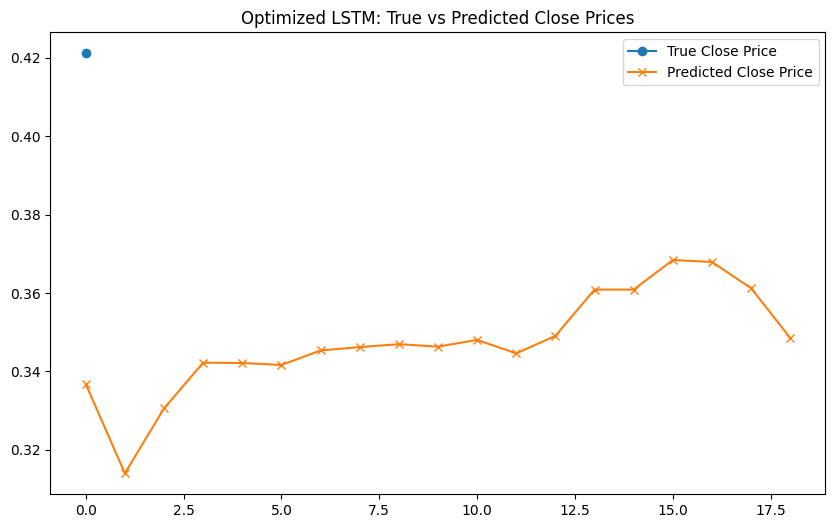

In [31]:
# Plot true vs predicted values for the 'Close' feature
lstm_optimized_true_close = y_test.reshape(-1, 5)[:, 3]  # True 'Close' values
lstm_optimized_pred_close = lstm_optimized_y_pred.reshape(-1, 5)[:, 3]  # Predicted 'Close' values

plt.figure(figsize=(10, 6))
plt.plot(lstm_optimized_true_close, label='True Close Price', marker='o')
plt.plot(lstm_optimized_pred_close, label='Predicted Close Price', marker='x')
plt.title('Optimized LSTM: True vs Predicted Close Prices')
plt.legend()
plt.show()

### Merged Visualization

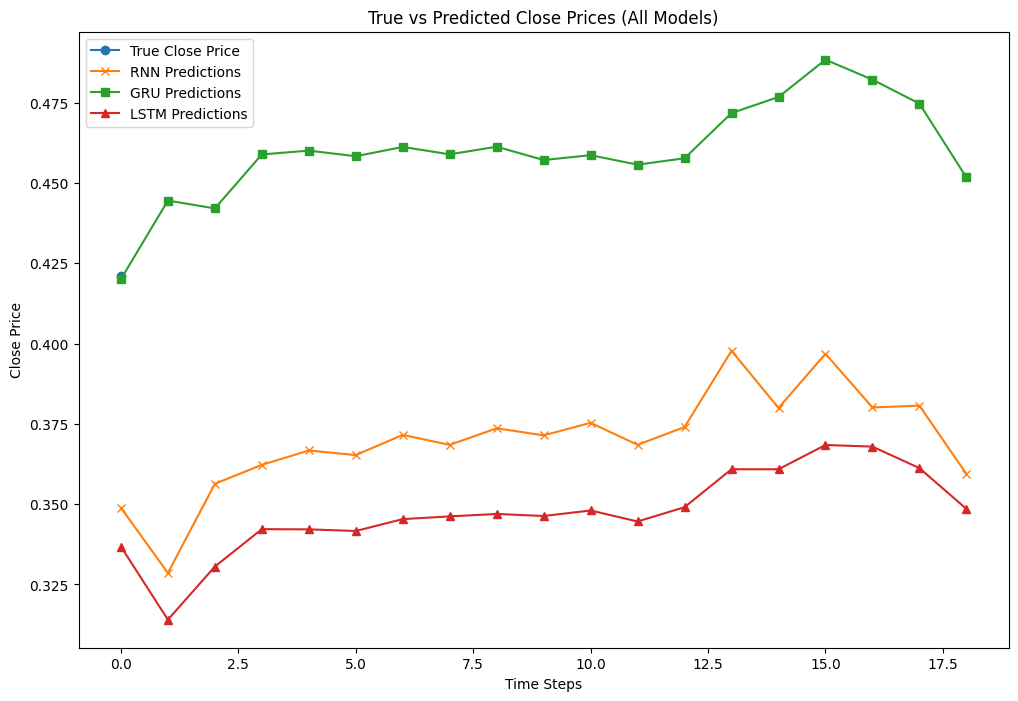

In [44]:
# Plot true vs predicted values for all models
plt.figure(figsize=(12, 8))

# True close values
plt.plot(rnn_optimized_true_close, label='True Close Price', marker='o')

# Predicted close prices for each model
plt.plot(rnn_optimized_pred_close, label='RNN Predictions', marker='x')
plt.plot(gru_optimized_pred_close, label='GRU Predictions', marker='s')
plt.plot(lstm_optimized_pred_close, label='LSTM Predictions', marker='^')

# Title, labels, and legend
plt.title('True vs Predicted Close Prices (All Models)')
plt.xlabel('Time Steps')
plt.ylabel('Close Price')
plt.legend()
plt.show()

### Comparison Table

In [46]:
import pandas as pd

# Create a DataFrame for comparison with MSE only
comparison_table = pd.DataFrame({
    'Model': ['RNN', 'GRU', 'LSTM'],
    'MSE': [rnn_optimized_test_loss, gru_optimized_test_loss, lstm_optimized_test_loss]
})

# Display the table
print(comparison_table)

  Model       MSE
0   RNN  0.001927
1   GRU  0.001349
2  LSTM  0.001768
